In [1]:
%%time
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import pandas as pd
import numpy as np
import scipy.io.wavfile
from scipy import fftpack

import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

from os import sep
from os.path import isfile, join, abspath, expanduser
from moviepy.editor import AudioFileClip, VideoFileClip
#from moviepy.video.io.VideoFileClip import VideoFileClip, AudioFileClip

from sklearn.decomposition import PCA
from sklearn.externals import joblib
from ggplot import *

CPU times: user 1.13 s, sys: 195 ms, total: 1.33 s
Wall time: 1.52 s


# Load model, load video into a byte array, perform FFT

In [2]:
dirpath = join(abspath(sep),'Users/brianschneider/Desktop/capstone/gameSummarizer')
file_basename = 'test_tri_usa_2nd_half_eng'
videoFileName = join(dirpath, file_basename+'.mp4')
model = joblib.load('model_ensemble.pkl') 
pca_model = joblib.load('model_pca.pkl') 

In [3]:
%%time
F = []
samprate = 44100
#print row['secondOffset'], row['timeToCapture']
if isfile(videoFileName):
    audioClip = AudioFileClip(videoFileName)
    print('Video duration: {0}'.format(audioClip.duration))
    wavClip = audioClip.to_soundarray(fps=samprate)
    wavClip = wavClip[:samprate*int(audioClip.duration),]
    wavdata = wavClip.reshape(-1, samprate,  2)
    dims = wavdata.shape
    for sec in np.arange(dims[0]):
        ch1 = scipy.fftpack.fft(wavdata[sec,:,0])[:samprate//2] # Left channel
        ch2 = scipy.fftpack.fft(wavdata[sec,:,1])[:samprate//2] # Right channel
        ch = np.vstack([ch1,ch2])
        F.append(ch)
    del audioClip
else:
    print('Could not find file ', videoFileName)

F = np.absolute(F)/samprate
F_db = 20*np.log10(2*F)  # Dimensions are (seconds, channels, samples)
f = scipy.fftpack.fftfreq(samprate, 1.0/samprate)[:samprate//2]

Video duration: 3038.85
CPU times: user 16.1 s, sys: 3.37 s, total: 19.5 s
Wall time: 25 s


# Predict each second's likelihood of being interesting

In [4]:
print(F_db.shape)
F2 = F.reshape(F_db.shape[0],-1)
print (F2.shape)

(3038, 2, 22050)
(3038, 44100)


In [5]:
%%time
index=np.array(np.arange(F2.shape[0]))
data= pca_model.transform(F2)
N=10 # Running average breadth
print(data.shape)

predicted_labels = model.predict(data)
predicted_proba = model.predict_proba(data)
running_predicted_labels = pd.rolling_mean(predicted_proba[:,0], N) # 0 means "goal"
print(predicted_proba.shape)
print(running_predicted_labels.shape)


(3038, 170)
(3038, 3)
(3038,)
CPU times: user 4.76 s, sys: 295 ms, total: 5.05 s
Wall time: 2.54 s


In [6]:
def on_plot_hover(event):
    for curve in plot.get_lines():
        if curve.contains(event)[0]:
            print("over %s" % curve.get_gid())
            
def plotGame(i,g):
    fig = plt.figure(figsize=(15, 6))
    plot = plt.plot(i,g, alpha=0.5)
    fig.canvas.mpl_connect('motion_notify_event', on_plot_hover)           
    plt.xlabel('Game Seconds')
    plt.ylabel('Goal Likelihood')
    plt.show()

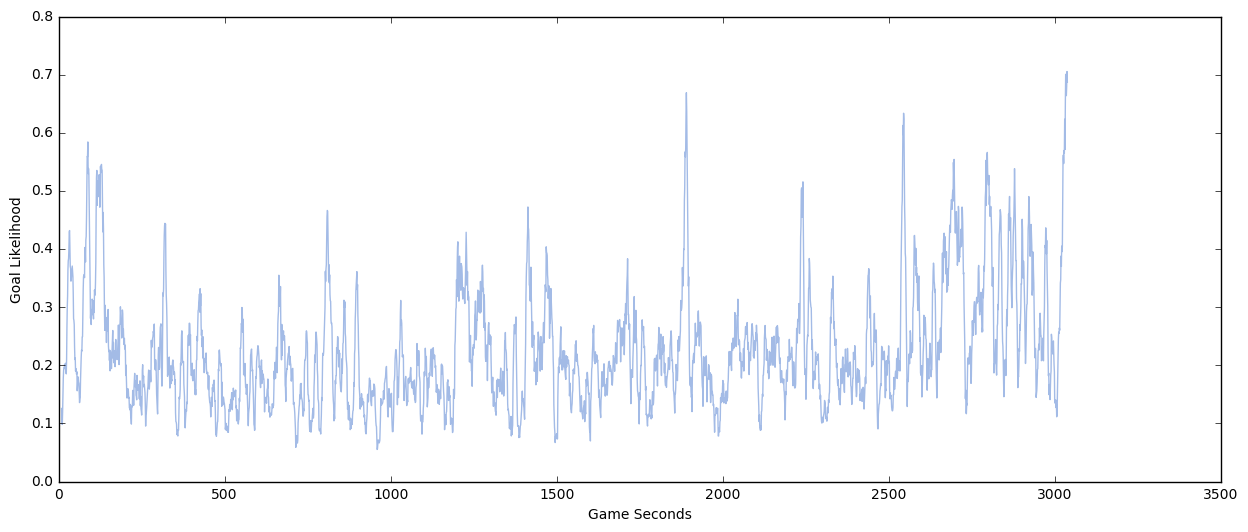

In [7]:
plotGame(index, running_predicted_labels)

# Determine distinct events

In [8]:
indexed_running_predicted_labels = np.argsort(running_predicted_labels)
eventsFounds=0
events=[]
for idx in reversed(indexed_running_predicted_labels[:len(running_predicted_labels)-(N-1)]):
    found=False
    for e in events:
        if idx >= e["start"] and idx-10 <= e["end"]:
            if found == True:
                remember_e=e["end"]
                remember_s=e["start"]
                events.remove(e)
                for e2 in events:
                    if  idx >= e2["start"] and idx-10 <= e2["end"]:
                        e2["start"] = min(e2["start"],remember_s)
                        e2["end"] = max(e2["end"],remember_e)
            else:
                if idx > e["end"]:
                    e["end"] = idx
                found=True
        elif idx+1 == e["start"]:
            e["start"] = idx
            if found == True:
                remember=e["end"]
                events.remove(e)
                for e2 in events:
                    if e2["end"] == idx:
                        e2["end"] = remember
            else:
                found=True
        elif idx-1 == e["end"]:
            e["end"] = idx
            if found == True:
                remember=e["start"]
                events.remove(e)
                for e2 in events:
                    if e2["start"] == idx:
                        e2["start"] = remember
            else:
                found=True
    if found == False:
        eventsFounds+=1
        event={"peak" : idx, "start" : idx-10, "end" : idx}
        events.append(event)
    if eventsFounds>15:
        break
for event in events:
    print(event)

{'peak': 3036, 'end': 3037, 'start': 3023}
{'peak': 1890, 'end': 1894, 'start': 1880}
{'peak': 2544, 'end': 2547, 'start': 2534}
{'peak': 88, 'end': 92, 'start': 78}
{'peak': 2796, 'end': 2807, 'start': 2786}
{'peak': 2696, 'end': 2698, 'start': 2686}
{'peak': 129, 'end': 132, 'start': 105}
{'peak': 2878, 'end': 2879, 'start': 2868}
{'peak': 2241, 'end': 2241, 'start': 2231}
{'peak': 2863, 'end': 2863, 'start': 2853}
{'peak': 2921, 'end': 2922, 'start': 2911}
{'peak': 2709, 'end': 2709, 'start': 2699}
{'peak': 1413, 'end': 1413, 'start': 1403}
{'peak': 2720, 'end': 2720, 'start': 2710}
{'peak': 2835, 'end': 2835, 'start': 2825}


In [9]:
%%time
# scenedetect -i mag_dor_1st_half_eng.mp4 -d content -t 28 -st 152s -et 231s -co scenes.csv -fs 1 -p 85 -df 3 -q

import scenedetect
scene_list = []        # Scenes will be added to this list in detect_scenes().

# Usually use one detector, but multiple can be used.
# scenedetect.detectors.ThresholdDetector(threshold = 8, min_percent = 0.5)
detector_list = [
    scenedetect.detectors.ContentDetector(threshold = 28, min_scene_len = 10)
]

# videoFileName='/Users/Roy/Downloads/videos/MON_V_MONT_1H_ESP_highlight.mp4'
video_framerate, frames_read = scenedetect.detect_scenes_file(
    videoFileName, scene_list, detector_list, frame_skip = 2, timecode_list=[152*25,231*25,-1])

# scene_list now contains the frame numbers of scene boundaries.
print(scene_list)

# create new list with scene boundaries in milliseconds instead of frame #.
scene_list_msec = [(1000.0 * x) / float(video_framerate) for x in scene_list]

# create new list with scene boundaries in timecode strings ("HH:MM:SS.nnn").
scene_list_tc = [scenedetect.timecodes.get_string(x) for x in scene_list_msec]

[PySceneDetect] Parsing video test_tri_usa_2nd_half_eng.mp4...
[PySceneDetect] Video Resolution / Framerate: 1280 x 720 / 58.824 FPS
Verify that the above parameters are correct (especially framerate, use --force-fps to correct if required).
[4987, 5293, 5323, 5548, 5701]
CPU times: user 23.1 s, sys: 4.21 s, total: 27.3 s
Wall time: 17.7 s


# Play a video clip

In [10]:
# def getClip(path,offset,length):
#     videoClip = VideoFileClip(path).subclip(offset,offset+length)
#     print('Playing {0}, offset={1}, length={2}'.format(path,offset,length))
#     return videoClip

In [11]:
# clip = getClip(videoFileName,87, 119-87)  
# #clip = getClip(videoFileName,1798, 1830-1798)  
# #clip = getClip(videoFileName,2296, 2310-2296)  
# #clip = getClip(videoFileName,1669, 1685-1669)  
# #clip = getClip(videoFileName,478, 488-478)  
# #clip = getClip(videoFileName,1669, 1685-1669)  
# #clip = getClip(videoFileName,1188, 1200-1188)  
# #clip = getClip(videoFileName,1214, 1224-1214)  
# #clip = getClip(videoFileName,2362, 2379-2362)  

# clip.ipython_display(width=480, autoplay=True) 